In [75]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from state import AgentState

tavily_tool = DuckDuckGoSearchRun(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n python\n{code}\n\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [90]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from azure.identity import DefaultAzureCredential,get_bearer_token_provider

token_provider = get_bearer_token_provider(DefaultAzureCredential(),"https://cognitiveservices.azure.com/.default")
llm= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4o-mini",
    model= "gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)




search_tool = DuckDuckGoSearchRun(max_results =2)


search_agent = create_react_agent(
    llm, 
    [search_tool],
    prompt="You are a helpful assistant to fetch data from web search"
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt="You can only generate charts. You are working with a researcher colleague."
)


# def research_node(state: AgentState) -> Command[Literal["chart_generator", END]]:
#     result = research_agent.invoke(state)
#     state.messages[-1] = HumanMessage(
#         content=result["messages"][-1].content
#     )
#     return Command(update={"messages": state.messages,},goto="chart_generator")

def search_node(state: AgentState) -> Command[Literal["chart_node",END]]:
    result= search_agent.invoke(state)
    state.messages[-1]=HumanMessage(
        content=result["messages"][-1].content
    )
    state.sender="search_node"
    return Command(goto="chart_node",update={"messages" : state.messages,})


def chart_node(state: AgentState) -> Command[Literal["search_node",END]]:
    result= code_agent.invoke(state)
    state.messages[-1]=HumanMessage(
        content=result["messages"][-1].content
    )
    state.sender="chart_node"
    return Command(goto="search_node",update={"messages" : state.messages,})




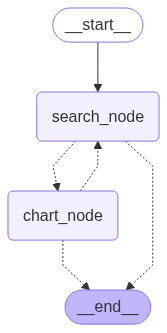

In [91]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("search_node", search_node)
workflow.add_node("chart_node", chart_node)

workflow.add_edge(START, "search_node")
graph = workflow.compile()
graph